# Time Series Analysis

This file shall develop and test functions that compute the following in relation to analysis of time series data.
1. Time series decomposition into trend, seasonality and residuals.
2. Augmented Dickey Fuller test to check for stationarity of data.
3. First Order Differencing.
4. Auto Correlation Function (ACF).
5. Partial Auto Correlation Function (PACF).

In [333]:
# Required python packages.
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [55]:
def validate_data_form(data):
    """
    Validates if data is in correct format and return True when it is so. 
    @param data: Input data.
    @return: True if data is in expected form. Throws exception otherwise.
    """
    if type(data) != type({}): 
        raise Exception('Unrecognized form of data.')
    if not 'data' in data.keys(): 
        raise Exception('Unrecognized form of data.')
    if not 'time' in data.keys(): 
        raise Exception('Unrecognized form of data.')
    if len(data['data']) != len(data['time']): 
        raise Exception('Data must have same length data and time values.')
    if len(data['data']) == 0: 
        raise Exception('No data received.')
    if not 'float' in str(type(data['data'][0])): 
        raise Exception('Data must be floats.')
    try: 
        pd.to_datetime(data['time'])
    except Exception as e: 
        raise Exception(f'Time could not be converted into pandas datetime format. {e}')
    return True

In [132]:
def add_freq(idx, freq=None):
    """
    Adds a frequency attribute to idx, through inference or directly.
    @param idx: Index to add frequency to.
    @param freq: Frequency to add.
    @return idx: Copy of given idx with frequency offset information added.
    """
    idx = idx.copy()
    if freq is None:
        if idx.freq is None: freq = pd.infer_freq(idx) # If freq is none, infer it.
        else: return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq) # Set to given frequency offset.
    if idx.freq is None: # If no freq is given and given idx has no freq, throw error.
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

In [195]:
def make_dataframe(data, freq):
    """ 
    Converts given data into a data frame with the time column
    set as the index with a given frequency.
    A list of valid pandas frequency offsets is available at: 
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases.
    Missing values will be filled in using first forward and then backward fill.
    """
    df = pd.DataFrame(data)
    df.set_index("time", inplace=True)
    df = df.asfreq(freq)
    df = df.ffill().bfill()
    return df

In [196]:
# Loading some dummy data for experimentation.

# data_bikes = pd.read_csv('___DummyData/dublinbikes.csv')
# with open('___DummyData/air.json', 'r') as f:
#     data_air = json.load(f)
# data = {'time': pd.to_datetime(data_bikes.day), 'data': data_bikes.usage}
# validate_data_form(data)

data_air = pd.read_json('___DummyData/air.json')
data = {
    'time': pd.to_datetime(data_air.datetime),
    'data': data_air.pm2_5
}

# First step in being able to perform desired processing is to 
# convert given data into a pandas data frame.
df = make_dataframe(data, "30min")
df

,data
time,
2024-02-01 15:30:00,13.21
2024-02-01 16:00:00,10.77
2024-02-01 16:30:00,12.87
2024-02-01 17:00:00,13.93
2024-02-01 17:30:00,10.54
...,...
2024-02-08 13:00:00,0.00
2024-02-08 13:30:00,0.00
2024-02-08 14:00:00,0.00


## 1. Time Series Decomposition

In [243]:
def decompose_time_series(data, period, model_type='additive'):
    """
    Decomposes a time series into trend, seasonality, and residual components.
    @param data: Data series that is to be decomposed.
    @param period: No. of samples in a season. After how many observation would you like
                   to assume that there are repetitions?
    @param model_type: Type of decomposition (additive or multiplicative).
    @return dict: A dictionary containing the decomposed components (trend, seasonal, residual).
    """
    # Set time as index of the data frame in preparation for decomposition.

    # Perform seasonal decomposition.
    if model_type == 'multiplicative' and data.eq(0).any():
        # If there are 0s in the data, then it must be offset by 1
        # in order to perform multiplicative decomposition.
        data = data + 1
    decomposition = seasonal_decompose(data, model=model_type, period=period)
    
    # Extract decomposed components.
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Convert components to lists for easier manipulation.
    trend_list = trend.values.flatten().tolist()
    seasonal_list = seasonal.values.flatten().tolist()
    residual_list = residual.values.flatten().tolist()
    
    # Return decomposed components as a dictionary.
    return {
        "trend": trend_list,
        "seasonal": seasonal_list,
        "residual": residual_list
    }

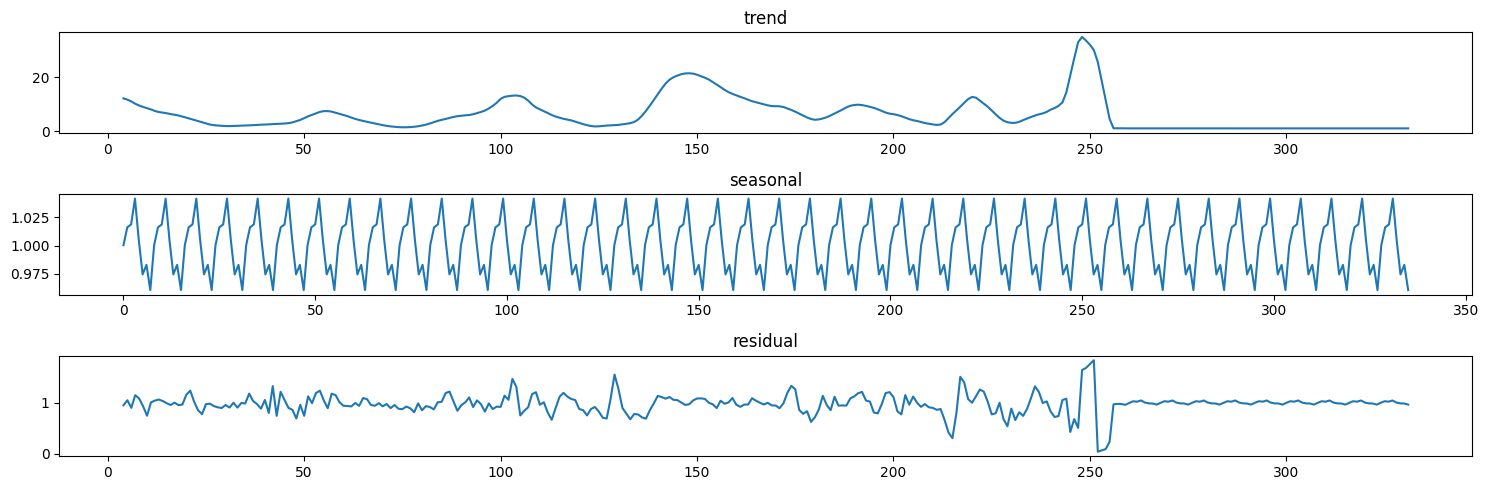

In [244]:
decomp = decompose_time_series(df.data, period=8, model_type='multiplicative')
df_decomp = pd.DataFrame(decomp)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 5))
axes[0].plot(df_decomp.trend)
axes[0].set_title('trend')
axes[1].plot(df_decomp.seasonal)
axes[1].set_title('seasonal')
axes[2].plot(df_decomp.residual)
axes[2].set_title('residual')
plt.tight_layout()

# 2. Stationarity Check

In [245]:
def adf_stationarity_check(data):
    """
    Performs Augmented Dickey Fuller (ADF) test to check for stationarity of data.
    @param data: Data series that is to be tested.
    @return dict: {
        "is_stationary": True if data is stationary and false otherwise.
        "adf": ADF test statistic.
        "p": Hypothesis test p value.
        "num_lags": No. of lags used.
        "num_obs": No. of observations used for ADF regression and critical value computation.
    }
    """
    adf_res = adfuller(data)
    adf = adf_res[0]
    p = adf_res[1]
    num_lags = adf_res[2]
    num_obs = adf_res[3]
    is_stationary = p < 0.05
    return { 
        "is_stationary": is_stationary, 
        "adf": adf, 
        "p": p, 
        "num_lags": num_lags, 
        "num_obs": num_obs
    }

In [246]:
adf_stationarity_check(df.data)

{'is_stationary': True,
 'adf': -3.8159890924039446,
 'p': 0.002747897349068927,
 'num_lags': 8,
 'num_obs': 327}

# 3. Differencing

In [256]:
def compute_first_difference(series):
    """
    Computes first order difference of given data to possibly make it
    stationary.
    @param series: Pandas series that needs to be differenced.
    @return diff: Differenced data.
    """
    dist = series[(series.index.values)[0:len(series)-1]].to_numpy()
    diff = series[(series.index.values)[1:len(series)]].to_numpy() - dist
    # def diff_inverse (data_diff):
    #     return np.insert(data_diff + dist, 0, dist[0:1])
    return diff

In [257]:
diff1 = compute_first_difference(df.data)
adf_stationarity_check(diff1)

{'is_stationary': True,
 'adf': -8.929046562617835,
 'p': 9.929638488952218e-15,
 'num_lags': 7,
 'num_obs': 327}

# 4. ACF

In [356]:
def compute_acf(data, lags):
    """
    Computes autocorrelation between lags for given no. of lags.
    @param data: Data to compute autocorrelation for.
    @param lags: No of lags to consider.
    @return dict: {
        "lag": List of lags from 1 to given max lag.
        "autocorrelation": Autocorrelation computed for each lag.
        "confidence_interval": Confidence intervals associated with each lag.
    }
    """
    res_acf = acf(data, nlags=lags)
    num_obs = len(data)

    # Compute the quantile function = inverse cumulative distribution function
    # of the standard normal distribution at 95% confidence level to get z value.
    z_critical = norm.ppf(1 - 0.05 / (2 * num_obs))  # 95% confidence level

    # Calculate confidence intervals for each lag
    # using the formula: Confidence Intervals = Z Score/sqrt(degrees of freedom)
    # wherein the z score is set as the value associated with 95% confidence level.
    conf_intervals = z_critical / np.sqrt(num_obs - np.arange(1, lags + 1))

    return {
        "lag": list(range(1, lags + 1)),
        "autocorrelation": res_acf[1:lags + 1],
        "confidence_interval": conf_intervals
    }

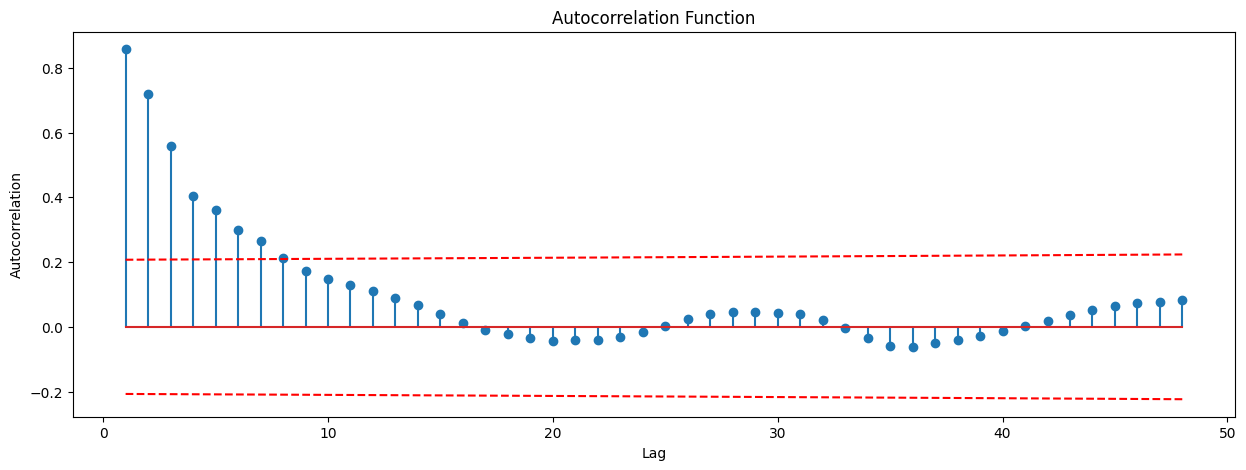

In [357]:
# Calculate autocorrelation and confidence intervals
res_acf = compute_acf(df.data, lags=48)

plt.figure(figsize=(15, 5))
plt.stem(res_acf['lag'], res_acf['autocorrelation'])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')

# Plot confidence intervals
plt.plot(res_acf['lag'], res_acf['confidence_interval'], color='red', linestyle='--')
plt.plot(res_acf['lag'], -1 * res_acf['confidence_interval'], color='red', linestyle='--')

plt.show()

# 5. PACF

In [360]:
def compute_pacf(data, lags):
    """
    Computes partial autocorrelation between lags for given no. of lags.
    @param data: Data to compute autocorrelation for.
    @param lags: No of lags to consider.
    @return dict: {
        "lag": List of lags from 1 to given max lag.
        "partial_autocorrelation": Partial autocorrelation computed for each lag.
        "confidence_interval": Confidence intervals associated with each lag.
    }
    """
    res_pacf = pacf(data, nlags=lags)
    num_obs = len(data)

    # Compute the quantile function = inverse cumulative distribution function
    # of the standard normal distribution at 95% confidence level to get z value.
    z_critical = norm.ppf(1 - 0.05 / (2 * num_obs))  # 95% confidence level

    # Calculate confidence intervals for each lag
    # using the formula: Confidence Intervals = Z Score/sqrt(degrees of freedom)
    # wherein the z score is set as the value associated with 95% confidence level.
    conf_intervals = z_critical / np.sqrt(num_obs - np.arange(1, lags + 1))

    return {
        "lag": list(range(1, lags + 1)),
        "partial_autocorrelation": res_pacf[1:lags + 1],
        "confidence_interval": conf_intervals
    }

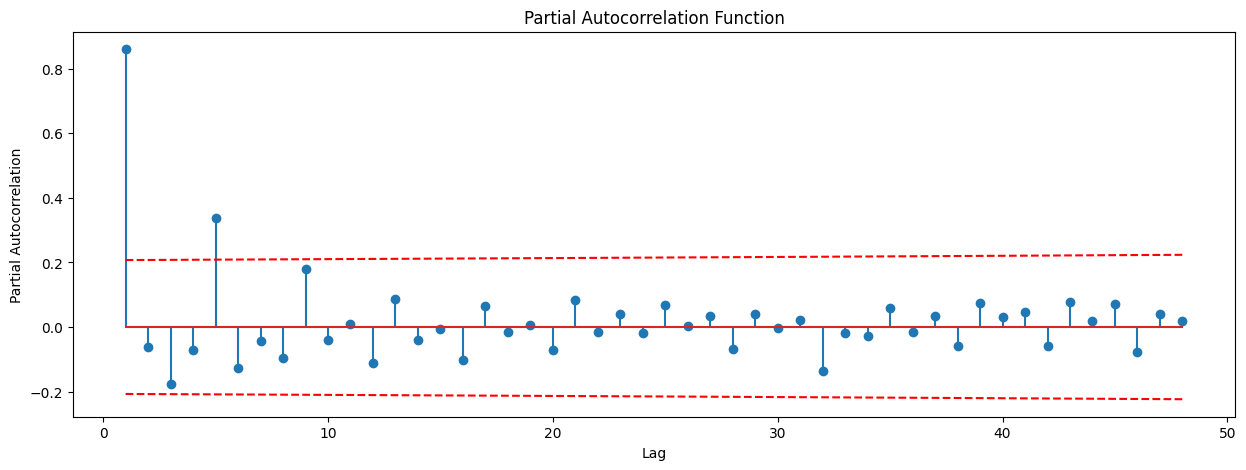

In [362]:
# Calculate autocorrelation and confidence intervals
res_pacf = compute_pacf(df.data, lags=48)

plt.figure(figsize=(15, 5))
plt.stem(res_pacf['lag'], res_pacf['partial_autocorrelation'])
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function')

# Plot confidence intervals
plt.plot(res_pacf['lag'], res_pacf['confidence_interval'], color='red', linestyle='--')
plt.plot(res_pacf['lag'], -1 * res_pacf['confidence_interval'], color='red', linestyle='--')

plt.show()